In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [2]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

In [35]:
def get_best_run(pde_name, pde_params, metric, opt, extensions, entity_name):
    proj_name = f'{pde_name}_{extensions[opt]}'

    best_run = None
    best_val = np.inf

    api = wandb.Api()
    for run in api.runs(f'{entity_name}/{proj_name}'):
        if run.state != 'finished':
            continue

        if run.config['pde_params'] != pde_params:
            continue

        if isinstance(run.summary[metric], (float, int)) and run.summary[metric] < best_val:
            best_run = run
            best_val = run.summary[metric]

    best_run_data = best_run.history(samples=int(1e6), keys=[metric], pandas=False)
    best_run_data = [dict[metric] for dict in best_run_data]

    return best_run_data

In [36]:
def get_title(pde_name, pde_params):
    if pde_name == "convection":
        return f'Convection, $\\beta = {pde_params[1]}$'
    if pde_name == "reaction":
        return f'Reaction, $\\rho = {pde_params[1]}$'
    elif pde_name == "reaction_diffusion":
        return f'Reaction-diffusion, $\\nu = {pde_params[1]}, \\rho = {pde_params[3]}$'
    elif pde_name == "wave":
        return f'Wave, $\\beta = {pde_params[1]}$'

In [37]:
def plot_best_performance_pde(pde, metric, opts, extensions, entity_name,
                              opt_names, metric_names, opt_colors, font_size, folder_path,
                              filename):
    mpl.rcParams.update({'font.size': font_size})

    fig, ax = plt.subplots(1, 1, figsize = (5, 4)) # Adjust figsize as needed 

    custom_legend_optimizers = [mpl.lines.Line2D([0], [0], color=opt_colors[opt], linestyle='-', label=opt_names[opt]) for opt in opts]

    pde_name = pde[0]
    pde_params = pde[1]

    for opt in opts:
        best_run_data = get_best_run(pde_name, pde_params, metric, opt, extensions, entity_name)

        x = np.arange(len(best_run_data))

        ax.plot(x, best_run_data, color=opt_colors[opt], linestyle='-')

    ax.set_yscale('log')
    ax.set_ylabel(metric_names[metric])
    ax.set_xlabel('Iterations / 20')
    ax.set_title(get_title(pde_name, pde_params))

    fig.legend(custom_legend_optimizers, [h.get_label() for h in custom_legend_optimizers], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(opts))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Saving the figure
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    filename = filename + '.pdf'
    fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
    plt.show()

In [38]:
entity_name = 'sketchy-opts'
extensions = {
    'adam': 'adam_final',
    'lbfgs': 'lbfgs_final',
    'adam_lbfgs': 'adam_lbfgs_final',
    'adam_lbfgs_11k': 'adam_lbfgs_final_11k',
    'adam_lbfgs_31k': 'adam_lbfgs_final_31k'
}
opt_names = {
    'adam': 'Adam',
    'lbfgs': 'L-BFGS',
    'adam_lbfgs': 'Adam + L-BFGS (1k)',
    'adam_lbfgs_11k': 'Adam + L-BFGS (11k)',
    'adam_lbfgs_31k': 'Adam + L-BFGS (31k)'
}
opt_colors = {
    'adam': 'tab:blue',
    'lbfgs': 'tab:orange',
    'adam_lbfgs': 'tab:green',
    'adam_lbfgs_11k': 'tab:red',
    'adam_lbfgs_31k': 'tab:purple'
}
metric_names = {
    'train/l2re': 'Training L2RE',
    'train/l1re': 'Training L1RE',
    'test/l2re': 'Test L2RE',
    'test/l1re': 'Test L1RE',
    'loss': 'Loss'
}

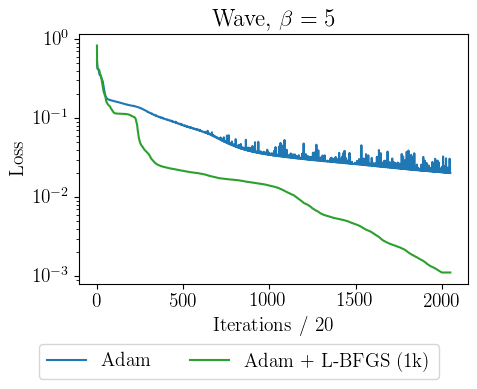

In [39]:
pde = ('wave', ['beta', '5'])
metric = 'loss'
opts = ['adam', 'adam_lbfgs']

folder_path = 'opt_comparison_plots'
filename = 'performance_wave'

plot_best_performance_pde(pde, metric, opts, extensions, entity_name, opt_names, metric_names, opt_colors,
                          font_size=14, folder_path=folder_path, filename=filename)